In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, date

%matplotlib inline

In [2]:
import seaborn as sns

In [55]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [4]:
sessions = pd.read_csv('./Data/sessions.csv')
train_users = pd.read_csv('./Data/train_users_2.csv')
test_users = pd.read_csv('./Data/test_users.csv')

In [5]:
print('Train objects: ', train_users.shape[0])
print('Test objects: ', test_users.shape[0])

Train objects:  213451
Test objects:  62096


In [6]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Колонка 'date_first_booking' всегда будет пуста на новых объектах, поэтому при обучении её нужно исключить из датасета.

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

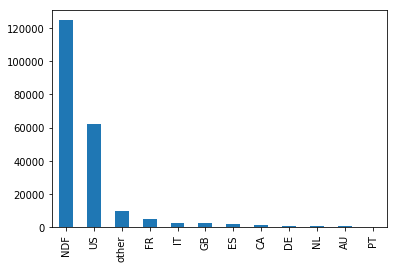

In [7]:
target = train_users['country_destination']
target.value_counts().plot('bar')
target.value_counts()

Большая часть пользователей не производила бронирование. Из остальных абсолютное большинство бронировали жилье в США. Выборка несбалансирована. Это нужно будет учитывать при построении модели.

In [8]:
target.value_counts()['NDF']/target.shape[0]

0.5834734904029496

58% новых пользователей не совершают бронирование

## Пропуски в данных

In [9]:
train_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

Видим много пропусков в колонке 'age'. Возможно, пользователи, не указавшие возраст при регистрации, не собираются бронировать жилье. Проверим эту гипотезу.

## Возраст

In [10]:
users_without_age = train_users.loc[train_users['age'].isnull()]

In [11]:
users_without_age['country_destination'].value_counts()

NDF      67614
US       13773
other     2518
FR        1310
IT         799
GB         550
ES         543
CA         351
DE         210
NL         160
AU         103
PT          59
Name: country_destination, dtype: int64

In [12]:
users_without_age['country_destination'].value_counts()['NDF']/users_without_age.shape[0]

0.7684282304807365

77% пользователей, не указавших возраст, не совершают первое бронирование, что превышает данный показатель по всей выборке.

Рассмотрим признак 'age' подробнее.

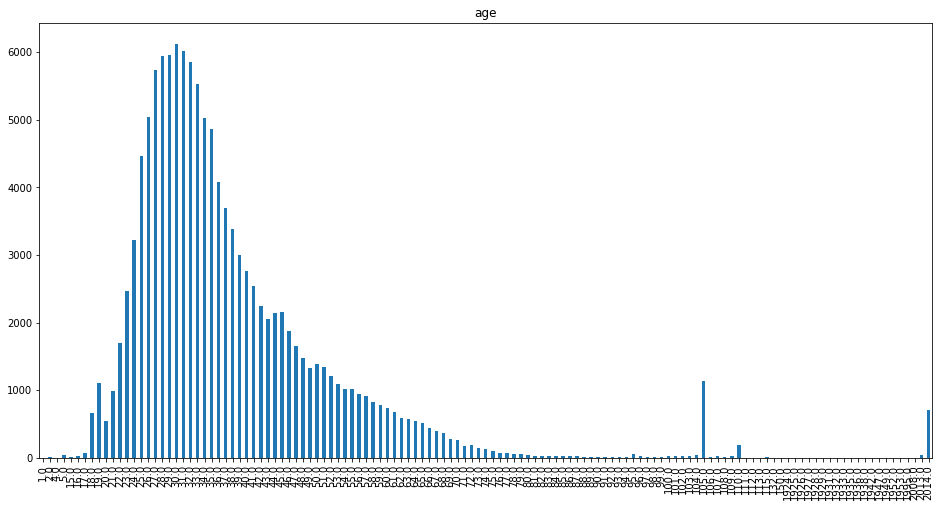

In [13]:
train_users['age'].value_counts().sort_index().plot('bar', title='age', figsize=(16,8));

В данных присутствуют люди с возрастом меньше 15 лет и больше 100 лет. Есть всплески количества людей с возрастом 105 и 110 лет, а также значения от 1915 до 2015, похожие на год рождения или текущий год (датасет был обновлен в 2015 году). Предположим, что в некоторых случаях люди ошибочно указывали год рождения вместо возраста. Посмотрим, как люди с аномальным возрастом бронируют недвижимость:

In [14]:
users_with_abnormal_age = train_users.loc[(train_users['age'] < 15) | (train_users['age'] > 100)]
print('В выборке {0} пользователей с аномальным возрастом.'.format(users_with_abnormal_age['country_destination'].shape[0]))
users_with_abnormal_age['country_destination'].value_counts()

В выборке 2402 пользователей с аномальным возрастом.


NDF      1067
US        933
other     164
FR         62
IT         48
GB         37
ES         30
CA         22
DE         17
NL         12
AU          8
PT          2
Name: country_destination, dtype: int64

Хотя таких пользователей всего 2402, больше половины из них делает бронирование. Зададим возрастное ограничение от 14 до 100 лет. Предположим, что значения от 1900 - годы рождения. Закодируем возрасты не из заданного диапазона специальными значениями:
- 0 для nan
- 5 для возраста меньше 14 лет
- 110 для возраста больше 100 лет

In [15]:
def process_age(df):
    ages = df['age'].values
    df['age'] = np.where(ages > 1915, 2015 - ages, ages)
    ages = df['age'].values
    df['age'] = np.where(ages < 14, 5, ages)
    ages = df['age'].values
    df['age'] = np.where(ages > 100, 110, ages)    
    df['age'].fillna(0, inplace=True)

In [16]:
users_df = train_users.copy()
process_age(users_df);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


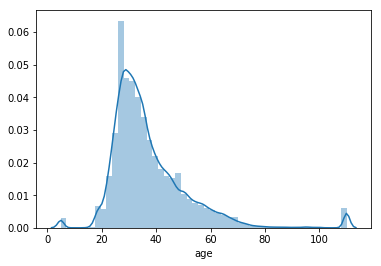

In [17]:
sns.distplot(users_df.loc[users_df['age'] > 0, 'age']);

Обычный возраст пользователей от 26 до 40 лет. Можно разбить пользователей на возрастные группы и добавить этот признак в модель.

## Пол

In [18]:
users_df['gender'].value_counts(dropna=False)

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [19]:
users_without_gender = users_df[users_df['gender'] == '-unknown-']
users_without_gender['country_destination'].value_counts()[0]/users_without_gender.shape[0]

0.696743583312432

In [20]:
users_with_gender = users_df.drop(users_without_gender.index.values)
users_with_gender['country_destination'].value_counts()[0]/users_with_gender.shape[0]

0.4914361896351146

Почти 70% пользователей, не указавших пол не делают заказ. Среди указавших пол пользователей тех, кто не делает заказ 50%.

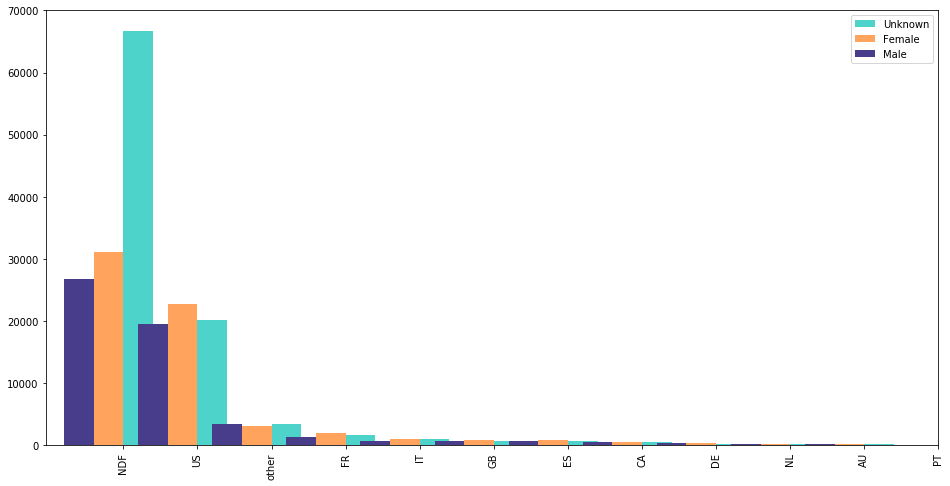

In [21]:
users_without_gender['country_destination'].value_counts().plot(kind='bar', label = 'Unknown', position=0, figsize=(16,8), width = 0.4, color='#4DD3C9')
users_with_gender.loc[users_with_gender['gender'] == 'FEMALE', 'country_destination'].value_counts().plot(kind='bar', label='Female', position=1, figsize=(16,8), width = 0.4, color='#FFA35D')
users_with_gender.loc[users_with_gender['gender'] == 'MALE', 'country_destination'].value_counts().plot(kind='bar', label='Male', position=2, figsize=(16,8), width = 0.4, color='#483D8B')

plt.legend()
plt.show()

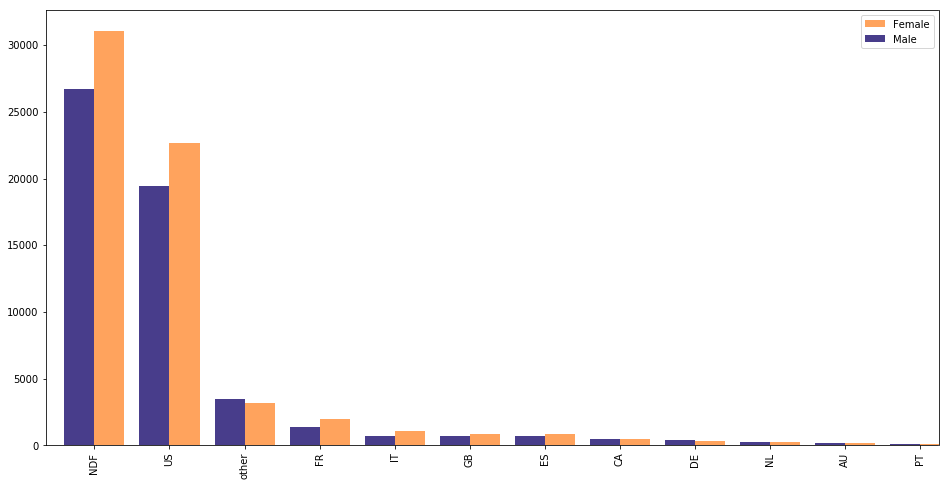

In [22]:
users_with_gender.loc[users_with_gender['gender'] == 'FEMALE', 'country_destination'].value_counts().plot(kind='bar', label='Female', position=0, figsize=(16,8), width = 0.4, color='#FFA35D')
users_with_gender.loc[users_with_gender['gender'] == 'MALE', 'country_destination'].value_counts().plot(kind='bar', label='Male', position=1, figsize=(16,8), width = 0.4, color='#483D8B')

plt.legend()
plt.show()

Мужчины и женщины выбирают страны для посещения в одинаковых пропорциях.

## Категориальные признаки

Посмотрим, как распределена целевая переменная в каждой категории категориальных признаков.

In [23]:
cat_features = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']

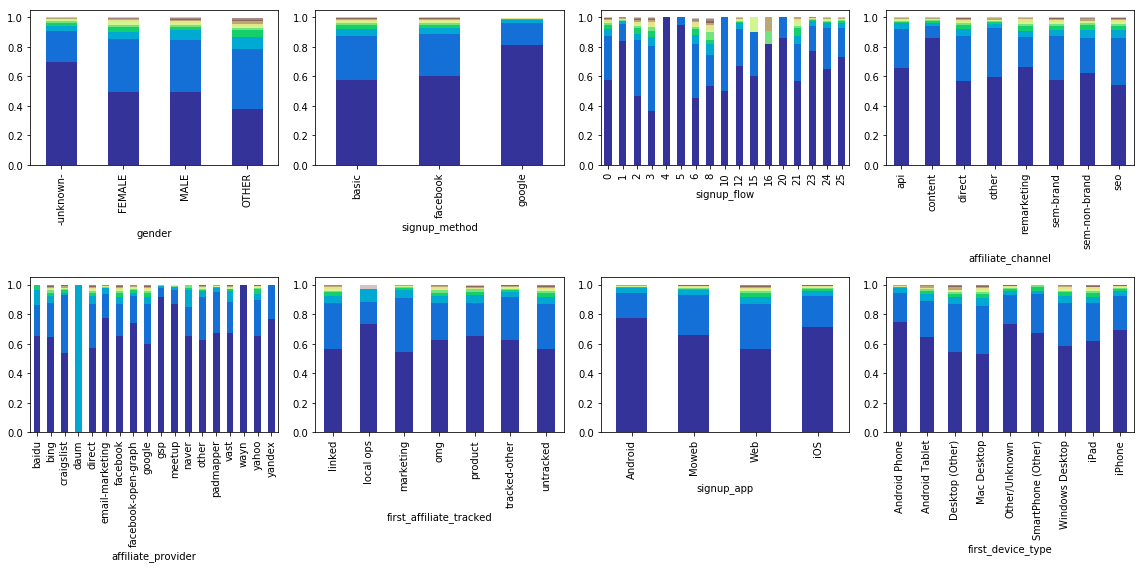

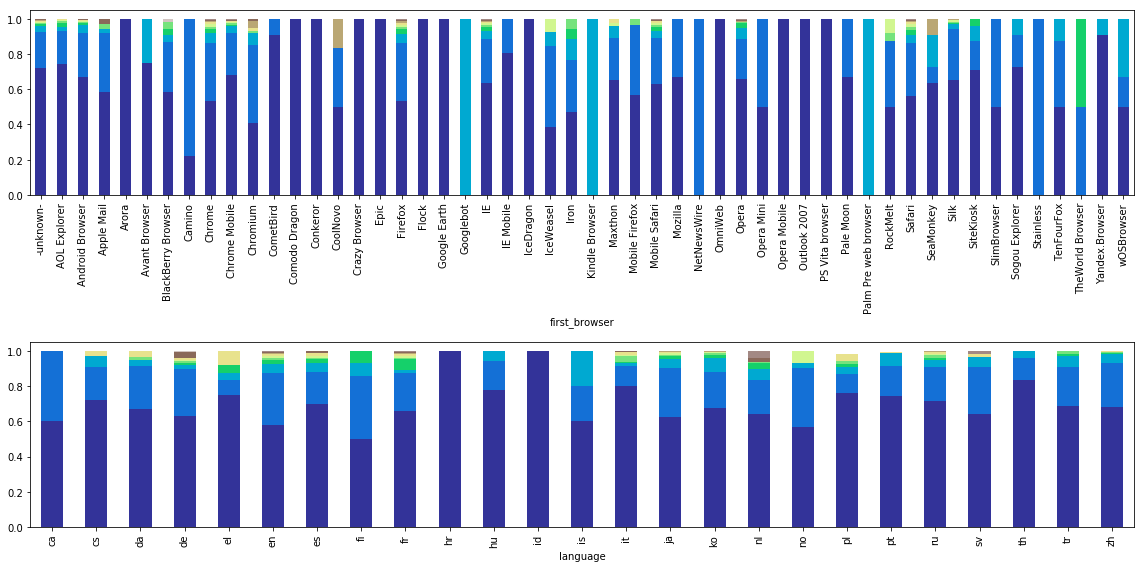

In [24]:
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
fig, ax1 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, feature in enumerate(cat_features[:8]):
    ctab = pd.crosstab([users_df[feature]], users_df['country_destination']).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=ax1.reshape(-1)[i],legend=False, colormap='terrain')
plt.tight_layout()
fig, ax2 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
for i, feature in enumerate(cat_features[8:]):
    ctab = pd.crosstab([users_df[feature]], users_df['country_destination']).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=ax2.reshape(-1)[i],legend=False, colormap='terrain')
plt.tight_layout()

- Люди со значением пола 'other' бронируют чаще остальных полов.
- Те, кто авторизуется через google бронируют меньше остальных.
- Люди с 'affilated_channel' = 'content' авторизуются реже остальных.
- Люди с 'signgup_flow' = 3 бронируют чаще.
- Люди с 'affilated_provider' 'craiglist' и 'direct' бронируют чаще.
- Люди чаще всего бронируют из web-приложения и реже всего - из android-приложения.
- Больше всего бронирований производится с Mac Desktop и меньше всего - с Android Phone, что сходится с пердыдущим наблюдением.
- В категории first_browser довольно много значений. Возможно, стоит оставить несколько самых популярных браузеров, а остальные выделить в отдельную категорию.
- Люди из некоторых языковых групп путешествуют более разнообразно.

## Базовая модель

Обучим первую модель на числовых и категориальных признаках из таблицы train_users. Исключим все временные признаки, id. Пропуски в колонке first_affiliate_tracked заменим текстом 'None'. В качестве метрики будем использовать accuracy.

In [25]:
# используем catboost, поскольку большая часть признаков - категориальные.
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.label import LabelEncoder

In [26]:
def process_nans(df):
    df['first_affiliate_tracked'].fillna('None', inplace=True)

In [27]:
# закодируем метки классов целыми числами для однозначного соответствия
le = LabelEncoder()
le.fit(train_users['country_destination'])

LabelEncoder()

In [28]:
# функция рассчета веса каждого класса в векторе y
# возьмем веса классов в обратной пропорции от количества объектов каждого класса в выборке
def get_class_weights(labels_s, num_classes):
    lbs, cnts = np.unique(labels_s, return_counts=True)
    weights = [0]*len(num_classes)    
    for l, c in zip(lbs, cnts):
        weights[l] = 1-c/labels_s.shape[0]
    return weights

In [29]:
# исключим из выборки колонки с датами, id и целевыю переменную
X = train_users.drop(['id','date_account_created','timestamp_first_active',
                   'date_first_booking','country_destination'], axis=1)
y = le.transform(train_users['country_destination'])
process_age(X)
process_nans(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
# указываем модели в каких колонках находятся категориальные признаки
cat_features_int = [0,2,3,4,5,6,7,8,9,10]

In [32]:
class_weights = get_class_weights(y_train, le.classes_)
class_weights

[0.9975111267275708,
 0.9932478332162099,
 0.9950046849379246,
 0.9894706020145233,
 0.9764991801358632,
 0.9893007730147576,
 0.9866889201218084,
 0.4161396111501523,
 0.9964453033497306,
 0.9989927383462169,
 0.7080639494026704,
 0.952635277582572]

In [33]:
# для простого сравнения моделей используем метрику accuracy.
# С помощью этой метрики мы можем сравнить построеные модели.
# Также эта метрика позволяет обучать CatBoost на GPU.
baseline_model = CatBoostClassifier(iterations = 500, 
                                    learning_rate = 0.2,
                                    depth = 6, 
                                    loss_function = 'MultiClass',
                                    eval_metric = 'Accuracy',
                                    class_weights=class_weights,                                    
                                    random_seed=42,
                                    task_type = "GPU")

In [34]:
train_pool = Pool(X_train, y_train, cat_features_int)
test_pool = Pool(X_test, y_test, cat_features_int)

In [35]:
baseline_model.fit(train_pool, use_best_model=True, eval_set=test_pool, verbose=False)

In [36]:
baseline_model.get_best_score()

{'learn': {'Accuracy': 0.5561833440255792, 'MultiClass': -1.2910532790296279},
 'validation_0': {'Accuracy': 0.553244790920247,
  'MultiClass': -1.343829937648684}}

Точность первой модели 0.55 на несбалансированных классах. Посмотрим, какие предсказания модель выдает чаще всего:

In [56]:
# Посмотрим, какие предсказания модель выдает чаще всего
baseline_model_preds = baseline_model.predict(test_pool)
classes, counts = np.unique(baseline_model_preds, return_counts=True)
print(le.inverse_transform(classes.astype(int)))
print(counts)

['FR' 'NDF' 'US' 'other']
[    3 24367 18279    42]


 Несмотря на использование весов классов модель подстроилась под статитстику датасета и почти всегда выдает два наибольших класса (7-NDF, 10-US).

In [38]:
def print_feature_importances(model):    
    for fn, fi in sorted(zip(model.feature_names_, model.feature_importances_), key=lambda x: x[1], reverse=True):
        print(f'{fn}: {fi:.2f}')

In [39]:
print_feature_importances(baseline_model)

age: 25.22
gender: 10.17
first_affiliate_tracked: 9.73
first_browser: 9.41
affiliate_channel: 9.21
first_device_type: 8.92
signup_flow: 8.22
signup_method: 8.12
affiliate_provider: 5.10
language: 3.45
signup_app: 2.46


## Новые признаки

Добавим больше информации в модель:
- Сократим количество категорий first_browser, чтобы убрать зашумленность этого признака аномалиями типа Kindle Browser
- Добавим возрастные группы, такие же, как в age_gender_bkts.csv
- Добавим различные признаки, связанные с датами (день, месяц, год, сезон и т.д.)
- Также добавим в качестве признаков разности между Datetime признаками.

In [40]:
train_users['first_browser'].value_counts()

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
Apple Mail                 36
IE Mobile                  36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
SeaMonkey                  11
CometBird                  11
Yandex.Browser             11
Camino                      9
TenFourFox                  8
wOSBrowser                  6
CoolNovo                    6
Opera Mini                  4
Avant Browser               4
Mozilla                     3
TheWorld B

In [41]:
def shrink_browser_cats(df):
    popular_browsers = ['Chrome', 'Safari', 'Firefox', '-unknown-', 'IE', 'Mobile Safari']
    
    df.loc[~df['first_browser'].isin(popular_browsers), 'first_browser'] = 'other'

Добавим признак возрастной группы.

In [42]:
def get_age_group_value(age, age_group):
    age_group_val = 20
    for i in range(len(age_group)):
        if age < age_group[i]:
            age_group_val = i 
            break
    return age_group_val


def add_age_groups(df):
    age_group =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
    df['age_group'] = df['age'].apply(get_age_group_value, args=(age_group,))

In [43]:
# сгенерируем признаки, связанные датами
Y = 2000
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'зима'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'весна'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'лето'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'осень'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'зима'

def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dt <= end)

def process_date_features(df):
    
    df['date_account_created'] = pd.to_datetime(df['date_account_created'])
    df['timestamp_first_active'] = pd.to_datetime((df['timestamp_first_active']), format='%Y%m%d%H%M%S')
    df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])
    
    dac_features = [[x.day, x.month, x.year, x.dayofweek, x.dayofyear, x.weekofyear] 
                for x in df['date_account_created']]
    dac_df = pd.DataFrame(data=dac_features, 
                        columns=['dac_d','dac_m','dac_y','dac_wd','dac_yd','dac_yw'],
                        index=df.index)
    
    tfa_features = [[x.day, x.month, x.year, x.dayofweek, x.dayofyear, x.weekofyear] 
                for x in df['timestamp_first_active']]
    tfa_df = pd.DataFrame(data=tfa_features, 
                        columns=['tfa_d','tfa_m','tfa_y','tfa_wd','tfa_yd','tfa_yw'],
                        index=df.index)
        
    df['dac_tfa_secs'] = np.array([np.log(1+abs(((dac-tfa)//10**9).astype(int)))
                                   for dac, tfa in df[['date_account_created','timestamp_first_active']].values])
    df['dac_tfa_sign'] = np.array([np.sign((dac-tfa).astype(int))
                                   for dac, tfa in df[['date_account_created','timestamp_first_active']].values])

    df['season_dac'] = np.array([get_season(dt) for dt in df['date_account_created']])
    df['season_tfa'] = np.array([get_season(dt) for dt in df['timestamp_first_active']])
    
    return pd.concat([df, dac_df, tfa_df], axis=1)

### Добавим новые признаки в выборку и обучим на них модель

In [44]:
def print_column_names(df):
    for i, name in enumerate(df.columns):
        print(f'{i:2d} : {name}')

In [45]:
tmp_df = train_users.copy()
process_nans(tmp_df)
process_age(tmp_df)
shrink_browser_cats(tmp_df)
add_age_groups(tmp_df)
tmp_df = process_date_features(tmp_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [46]:
X = tmp_df.drop(['id', 'date_account_created', 'timestamp_first_active',
                 'date_first_booking', 'country_destination'], axis=1)
y = le.transform(tmp_df['country_destination'])

In [47]:
# отобразим нумерацию признаков, чтобы правильно указать категориальные
print_column_names(X)

 0 : gender
 1 : age
 2 : signup_method
 3 : signup_flow
 4 : language
 5 : affiliate_channel
 6 : affiliate_provider
 7 : first_affiliate_tracked
 8 : signup_app
 9 : first_device_type
10 : first_browser
11 : age_group
12 : dac_tfa_secs
13 : dac_tfa_sign
14 : season_dac
15 : season_tfa
16 : dac_d
17 : dac_m
18 : dac_y
19 : dac_wd
20 : dac_yd
21 : dac_yw
22 : tfa_d
23 : tfa_m
24 : tfa_y
25 : tfa_wd
26 : tfa_yd
27 : tfa_yw


In [48]:
cat_features_int = [0,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25,26,27]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

train_pool = Pool(X_train, y_train, cat_features_int)
test_pool = Pool(X_test, y_test, cat_features_int)
class_weights = get_class_weights(y_train, le.classes_)

In [49]:
model_2 = CatBoostClassifier(iterations = 500, 
                             learning_rate = 0.2,
                             depth = 8, 
                             loss_function = 'MultiClass',
                             eval_metric = 'Accuracy',
                             class_weights=class_weights,
                             random_seed=42,
                             task_type = "GPU")

In [50]:
model_2.fit(train_pool, use_best_model=True, eval_set=test_pool, verbose=False)

In [51]:
model_2.get_best_score()

{'learn': {'Accuracy': 0.5971209377735236, 'MultiClass': -1.0652127965120073},
 'validation_0': {'Accuracy': 0.5539233714401176,
  'MultiClass': -1.338096188762701}}

In [52]:
print_feature_importances(model_2)

age_group: 10.06
dac_tfa_secs: 8.47
first_browser: 6.15
age: 5.63
tfa_yd: 5.56
gender: 4.81
first_affiliate_tracked: 4.71
signup_method: 4.41
dac_d: 4.39
first_device_type: 4.13
affiliate_channel: 3.93
tfa_y: 3.87
tfa_wd: 3.45
tfa_d: 3.30
tfa_m: 3.08
signup_flow: 2.90
tfa_yw: 2.86
dac_yd: 2.55
dac_wd: 2.53
dac_yw: 2.28
affiliate_provider: 2.25
dac_m: 1.78
dac_y: 1.77
season_tfa: 1.29
dac_tfa_sign: 1.26
season_dac: 1.03
signup_app: 0.82
language: 0.76


In [57]:
model_2_preds = model_2.predict(test_pool)
classes, counts = np.unique(model_2_preds, return_counts=True)
print(le.inverse_transform(classes.astype(int)))
print(counts)

['NDF' 'NL' 'US' 'other']
[24362     1 18321     7]


Как видим, с добавлением новых признаков модель по-прежнему выдает два самых популярных класса. Попробуем добавить признаки из сессий пользователя.

## Sessions

In [58]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [59]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [60]:
ses_df = sessions.copy()

In [61]:
ses_df['id'] = ses_df['user_id']
ses_df.drop('user_id', axis=1, inplace=True)

In [62]:
# Заменим все пропуски в категориальных признаках на NAN, а в длительности сессии - на 0.
def process_ses_nans(df):
    for col in ['action','action_type','action_detail']:
        df[col] = df[col].fillna('NAN')
    df.loc[:, 'secs_elapsed'].fillna(0, inplace=True)

In [63]:
process_ses_nans(ses_df)

In [64]:
# отнесем все редко встречающиеся действия в категорию other
def shrink_rare_actions(df):
    act_freq = 100
    action_counts = df['action'].value_counts()
    rare_actions = action_counts[action_counts < act_freq].index.tolist()
    df.loc[df['action'].isin(rare_actions), 'action'] = 'other'
    
    action_detail_counts = df['action_detail'].value_counts()
    rare_action_details = action_detail_counts[action_detail_counts < act_freq].index.tolist()
    df.loc[df['action_detail'].isin(rare_action_details), 'action_detail'] = 'other'

In [65]:
shrink_rare_actions(ses_df)

Собираем статистику по сессиям.

In [66]:
# пронумерованные списки всех значений категориальных переменных
action_list = ses_df['action'].value_counts().argsort()
action_detail_list = ses_df['action_detail'].value_counts().argsort()
action_type_list = ses_df['action_type'].value_counts().argsort()
device_type_list = ses_df['device_type'].value_counts().argsort()

feature_cats = {'action' : action_list,
                'action_detail' : action_detail_list,
                'action_type' : action_type_list,
                'device_type' : device_type_list}

In [67]:
# группируем сессии по пользователям
grouped_sessions = ses_df.groupby(['id'])

In [68]:
def get_group_counts(group, feature):
    
    counts = [0]*len(feature_cats[feature])    
    vc = group[1][feature].value_counts()
    for item, count in vc.items():
        # записываем количество категорий признака feature в позицию,
        # соответствующую номеру этой категории в списке action_list или др.
        counts[feature_cats[feature][item]] = count
    # рассчитываем статистики (количество, среднее, std) и добавляем их в конец списка
    counts += [vc.shape[0], vc.mean(), vc.std()]
    # возвращаем список, в котором содержится количество вхождений каждой категории выбранного признака
    # во всех сессиях данного пользователя + статистики по признаку.
    return counts

In [69]:
# имена колонок будущего датафрейма
col_names = ['ses_count']
for feat, vc_list in feature_cats.items():
    for cat_item in vc_list.index:
        col_names.append(f'{feat}_{cat_item}_c')
    col_names += [f'{feat}_count', f'{feat}_mean', f'{feat}_std']
col_names += ['se_log_sum', 'se_log_mean', 'se_log_std', 'se_log_median', 'se_mean_by_session']

In [70]:
%%time
samples = []
ids = []

for g in grouped_sessions:
    id = g[0]
    ids.append(id)
    # строка из id пользователя, количества сессий и статистик по всем его сессиям
    sample = [g[1].shape[0]]
    
    # статистики по значениям каждого категориального признака
    for feature in feature_cats.keys():
        sample += get_group_counts(g, feature)
        
    # статистики по длительности сессий
    secs_elapsed = g[1]['secs_elapsed']
    if g[1].shape[0] > 0:
        sample += [np.log(1+secs_elapsed.sum()),
                   np.log(1+secs_elapsed.mean()),
                   np.log(1+secs_elapsed.std()),
                   np.log(1+secs_elapsed.median()),
                   np.log(1+secs_elapsed.sum())/g[1].shape[0]]
    else:
        sample += [0, 0, 0, 0, 0]
    samples.append(sample)

Wall time: 22min 1s


In [71]:
sessions_stats = pd.DataFrame(data = np.array(samples, dtype=np.float64),
                              columns = col_names,
                              index=ids)

sessions_stats.index.name = 'id'
sessions_stats.fillna(0, inplace=True)

In [72]:
sessions_stats.head()

,ses_count,action_show_c,action_index_c,action_search_results_c,action_personalize_c,action_search_c,action_ajax_refresh_subtotal_c,action_update_c,action_similar_listings_c,action_social_connections_c,...,device_type_Blackberry_c,device_type_Opera Phone_c,device_type_count,device_type_mean,device_type_std,se_log_sum,se_log_mean,se_log_std,se_log_median,se_mean_by_session
id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.0,2.0,20.0,22.627417,13.673828,9.984994,11.419946,6.738152,0.341846
0010k6l0om,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,63.0,1.0,63.0,0.000000,13.282003,9.138974,10.025681,6.742881,0.210825
001wyh0pz8,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,90.0,0.000000,12.553082,8.053587,8.786033,7.007601,0.139479
0028jgx1x1,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,15.5,20.506097,12.601524,9.167638,9.786528,6.194405,0.406501
002qnbzfs5,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,394.5,538.108260,15.685323,9.014678,10.969499,6.212606,0.019880


In [ ]:
sessions_stats.to_csv('sessions_stats.csv')

In [ ]:
# sessions_stats = pd.read_csv('sessions_stats.csv', index_col=0)

Получилось 406 числовых признаков. Посмотрим, как их добавление повлияет на точность модели.

In [73]:
tmp_df = train_users.copy()
process_nans(tmp_df)
process_age(tmp_df)
shrink_browser_cats(tmp_df)
add_age_groups(tmp_df)
tmp_df = process_date_features(tmp_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [74]:
X = tmp_df.join(sessions_stats, on='id', how='left').fillna(-2)
X = X.drop(['id', 'date_account_created', 'timestamp_first_active',
                 'date_first_booking', 'country_destination'], axis=1)
y = le.transform(tmp_df['country_destination'])

In [75]:
cat_features_int = [0,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
train_pool = Pool(X_train, y_train, cat_features_int)
test_pool = Pool(X_test, y_test, cat_features_int)
class_weights = get_class_weights(y_train, le.classes_)

In [76]:
model_3 = CatBoostClassifier(iterations = 500, 
                             learning_rate = 0.2,
                             depth = 8, 
                             loss_function = 'MultiClass',
                             eval_metric = 'Accuracy',
                             class_weights=class_weights,
                             random_seed=42,
                             task_type = "GPU")

In [77]:
model_3.fit(train_pool, use_best_model=True, eval_set=test_pool, verbose=False)

In [78]:
model_3.get_best_score()

{'learn': {'Accuracy': 0.5929415531586993, 'MultiClass': -1.1516457489849325},
 'validation_0': {'Accuracy': 0.5675595993059506,
  'MultiClass': -1.3083330670663633}}

In [79]:
model_3_preds = model_3.predict(test_pool)
classes, counts = np.unique(model_3_preds, return_counts=True)
print(le.inverse_transform(classes.astype(int)))
print(counts)

['FR' 'IT' 'NDF' 'US' 'other']
[   10     2 24383 18265    31]


Точность модели немного улучшилась, модель предсказывает уже не только самые большие классы. Посмотрим, какой результат будет на Kaggle.

In [80]:
submission_df = test_users.copy()
process_nans(submission_df)
process_age(submission_df)
shrink_browser_cats(submission_df)
add_age_groups(submission_df)
submission_df = process_date_features(submission_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [81]:
X_submission = submission_df.join(sessions_stats, on='id', how='left').fillna(-2)
X_submission = X_submission.drop(['id', 'date_account_created', 'timestamp_first_active',
                 'date_first_booking'], axis=1)

In [82]:
submission_preds = model_3.predict_proba(X_submission)

In [83]:
ids = []
c = []
for i, id in enumerate(test_users['id']):
    ids.extend([id]*5)
    c.extend(le.inverse_transform(submission_preds[i].argsort()[::-1][:5].tolist()))
assert (len(ids) == len(c))

In [84]:
pd.DataFrame(np.vstack([ids, c]).T, columns=['id','country']).to_csv('submission.csv', index=False)

Модель показала довольно высокий результат на Kaggle: 0.87359. Видимо, балансировка классов дает не очень хорошую точность на несбалансированном датасете, но помогает сохранить разноообразие предсказаний модели. Поэтому при использовании метрики NDCG5, где у нас есть 5 попыток угадать правильный класс, получается достаточно хороший результат.